In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import seaborn as sns
from numba import njit
from scipy.stats import skew
from scipy.stats import binom
from functools import partial
np.set_printoptions(suppress=True)

# Import our bayesflow lib
from deep_bayes.models import BayesFlow, InvariantNetwork
from deep_bayes.training import train_online
from deep_bayes.losses import maximum_likelihood_loss
from deep_bayes.viz import plot_true_est_scatter, plot_true_est_posterior
import deep_bayes.diagnostics as diag

In [2]:
import tensorflow as tf
if tf.__version__.startswith('1'):
    tf.enable_eager_execution()

In [3]:
%matplotlib inline

# Helper functions

In [15]:
def plot_sbc(theta_samples, theta_test, param_names, bins=25, dpi=300,
            figsize=(24, 12), interval=0.99, show=True, filename=None, font_size=12):
    """
    Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018).
    """

    # Plot settings
    plt.rcParams['font.size'] = font_size
    N = int(theta_test.shape[0])
    

    f, axarr = plt.subplots(2, 4, figsize=figsize)
    axarr = axarr.flat

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test, axis=0)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / (bins+1))

    # Plot histograms
    for j in range(len(param_names)):
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f', bins=bins, alpha=0.95)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == 0:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')
    
    f.tight_layout()
    
    # Show, if specified
    if show:
        plt.show()
        
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=dpi)

# Simulator

In [5]:
@njit
def diffusion_trial(v, a, kappa, t_sat, ndt_c, ndt_w, dt, max_steps):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    x = a * 0.5
    b_u = a
    b_l = 0

    # Simulate a single DM path
    while (x > b_l and x < b_u and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0
        
        # Collapse boundaries
        t = dt * n_steps
        b_u = a - (a/2) * kappa * (t/(t + t_sat))
        b_l = (a/2) * kappa * (t/(t + t_sat))

    rt = n_steps * dt
    return rt + ndt_c if x >= b_l else -rt - ndt_w

@njit
def simulate_diffusion_condition(n_trials, v, a, kappa, t_sat, ndt_c, ndt_w, dt=0.001, max_steps=15000):
    """Simulates a diffusion process over an entire condition."""
    
    x = np.empty(n_trials)
    for i in range(n_trials):
        x[i] = diffusion_trial(v, a, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    return x


@njit
def simulate_diffusion_2_conds(theta, n_trials, dt=0.001, max_steps=15000):
    """Simulates a diffusion process for 2 conditions with 7 parameters (v1, v2, a1, a2, ndt1, ndt2, zr=0.5)"""
    
    n_trials_c1 = n_trials[0]
    n_trials_c2 = n_trials[1]
    
    
    v1, v2, a1, a2, kappa, t_sat, ndt_c, ndt_w = theta
    rt_c1 = simulate_diffusion_condition(n_trials_c1, v1, a1, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    rt_c2 = simulate_diffusion_condition(n_trials_c2, v2, a2, kappa, t_sat, ndt_c, ndt_w, dt, max_steps)
    rts = np.concatenate((rt_c1, rt_c2))
    return rts

def data_generator(batch_size, n_obs=None, to_tensor=True, n_obs_min=60, 
                   n_obs_max=60, include_criterion=True):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta) with the specified n_obs. If 
    n_obs is None, random number of trials for each condition are generated.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    n_obs      : tuple (int, int) or None -- the numebr of observations to draw from p(x|theta)
                                  for each condition
    n_obs_min  : int -- the minimum number of observations per condition
    n_obs_max  : int -- the maximum number of observations per condition
    to_tensor  : boolean -- converts theta and x to tensors if True
    include_criterion : boolean -- whether to set RTs < 0.3 or RT > 10 to missing (0), as in IAT analysis
    ----------
    
    Output:
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from prior
    # theta is a np.array of shape (batch_size, theta_dim)
    theta = prior(batch_size)
    
    # Fixed or random number of DM samples
    if n_obs is None:
        n_obs = np.random.randint(n_obs_min, n_obs_max+1, 2)
    
    # Generate data
    # x is a np.ndarray of shape (batch_size x n_obs, x_dim)
    x = np.apply_along_axis(simulate_diffusion_2_conds, axis=1, arr=theta, n_trials=n_obs)
    
    # Mark bullshit data with 0
    if include_criterion:
        x[np.abs(x) < 0.3] = 0.
        x[np.abs(x) > 10] = 0.
    
    # Assign conditions
    cond_arr = np.stack( batch_size * [np.concatenate((np.zeros(n_obs[0]), np.ones(n_obs[1])))] )
    x = np.stack((x, cond_arr), axis=-1)
    
    # Convert to tensor, if specified 
    if to_tensor:
        theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
    return {'theta': theta, 'x': x}

Collapse factor lower boundary:  -1.3244594594594592
Collapse factor upper boundary:  1.3244594594594592


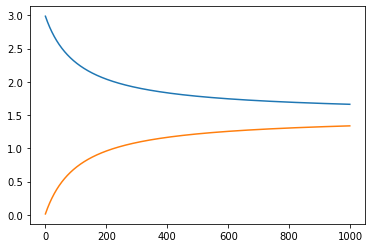

In [6]:
a = 3
kappa = 0.99
t_sat = 0.11
t = np.linspace(0.001, 1, 1000)

collapse_u = a - (a/2)*kappa * (t/(t + t_sat))


collapse_l = (a/2) * kappa * (t/(t + t_sat))

plt.plot(collapse_u)
plt.plot(collapse_l)

print('Collapse factor lower boundary: ', collapse_l[0] - collapse_l[-1])
print('Collapse factor upper boundary: ', collapse_u[0] - collapse_u[-1])

# Prior

In [7]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    
    Arguments:
    batch_size : int -- the number of samples to draw from the prior
    ----------
    
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Prior ranges for the simulator 
    # v ~ U(-7.0, 7.0)
    # a ~ U(0.1, 4.0)
    # kappa ~ U(0.01, 0.99)
    # t_sat ~ U(0.1, 3)
    # t0_p ~ U(0.1, 3.0)
    # t0_w ~ U(0.1, 7.0)
    theta = np.random.uniform(low=(0.1, 0.1, 0.1, 0.1, 0.01, 0.1, 0.1, 0.1), 
                              high=(7.0, 7.0, 4.0, 4.0, 0.99, 3.0, 3.0, 7.0), size=(batch_size, 8))
    return theta

# Summary Network Structure
Here, we will define the basic outline of a permutation-invariant neural network which maps raw reaction times data to outcomes.
<br>
See https://arxiv.org/pdf/1901.06082.pdf (p.28) for more details.

In [8]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta, pooler=tf.reduce_mean):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(InvariantModule, self).__init__()


        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])
        
        self.pooler = pooler
            

        self.post_pooling_dense = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_inv_args'])
            for _ in range(meta['n_dense_inv'])
        ])

    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        # Embed
        x_emb = self.module(x)

        # Pool representation
        pooled = self.pooler(x_emb, axis=1)
    
        # Increase representational power
        out = self.post_pooling_dense(pooled)
        return out


class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, meta):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        meta : dict -- a dictionary with hyperparameter name - values
        """

        super(EquivariantModule, self).__init__()

        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(**meta['dense_equiv_args'])
            for _ in range(meta['n_dense_equiv'])
        ])

        self.invariant_module = InvariantModule(meta)

    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out


class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, meta):
        """
        Creates a permutationally invariant network
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        meta : dict -- hyperparameter settings for the equivariant and invariant modules
        """

        super(InvariantNetwork, self).__init__()

        self.equiv = tf.keras.Sequential([
            EquivariantModule(meta)
            for _ in range(meta['n_equiv'])
        ])
        self.inv = InvariantModule(meta)

    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant
        representation by first passing it through multiple equivariant
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out

# Hyperparameter settings and model definition

In [9]:
# Neural network structure
summary_meta = {
    'dense_inv_args'   :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_equiv_args' :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'dense_post_args'  :  dict(units=64, activation='elu', kernel_initializer='glorot_normal'),
    'n_equiv'          :  2,
    'n_dense_inv'      :  3,
    'n_dense_equiv'    :  3,
}

# Network hyperparameters
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.00000,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 4

# Forward model hyperparameters
param_names = [r'$v_1$', r'$v_2$', r'$a_1$', r'$a_2$', r'$\kappa$', 
               r'$t_{0.5}$', r'$\tau_{c}$', r'$\tau_{w}$']
theta_dim = len(param_names)
n_test = 300
n_obs_max = 60
n_obs_min = 60
n_obs_test = (60, 60)

# Utility for online learning
data_gen = partial(data_generator, n_obs_min=n_obs_min, n_obs_max=n_obs_max)


# Training and optimizer hyperparameters
ckpt_file = "iat_bayesflow_collapsing"
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 2000
clip_value = 5.

learning_rate = 0.001
if tf.__version__.startswith('1'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
else:
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)               

In [10]:
summary_net = InvariantNetwork(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

# Create Test Data

In [21]:
%%time
test_data = data_generator(n_test, n_obs=n_obs_test)

Wall time: 350 ms


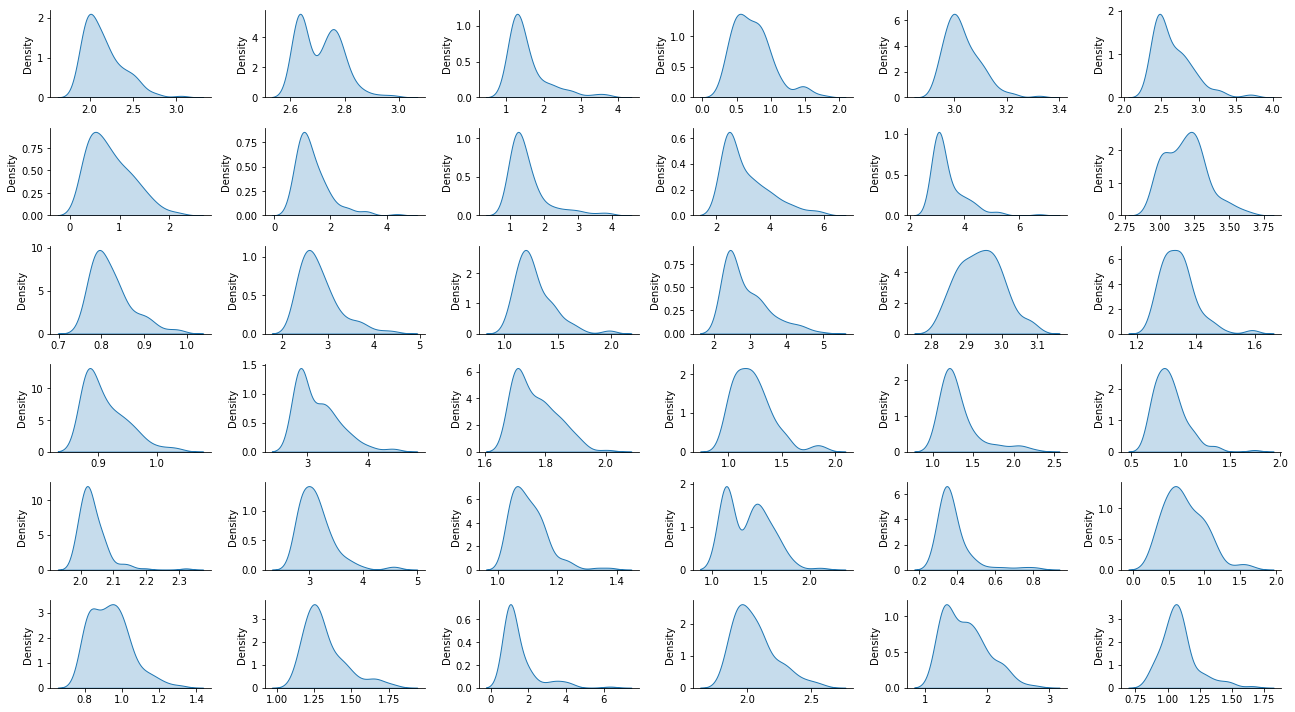

In [12]:
plot_data = data_generator(36, n_obs=(300, 300))
f, axarr = plt.subplots(6, 6, figsize=(18, 10))
for i in range(36):
    t_ = test_data['x'][i, :, :300][:, 0]
    t_ = t_[t_ > 0]
    sns.kdeplot(t_, ax=axarr.flat[i], shade=True)
    sns.despine(ax=axarr.flat[i])
f.tight_layout()

# Checkpoint manager
Used for saving/loading the model.

In [13]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/iat_bayesflow_col', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/iat_bayesflow\ckpt-49


# Domain Expertise Consistency

## Prior plots

In [234]:
n_check = 10000
n_samples_prior = 100000
check_data = data_generator(n_check, n_obs=n_obs_test, to_tensor=False, include_criterion=False)
prior_low=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) 
prior_high=(7.0, 7.0, 4.0, 4.0, 0.99, 3.0, 3.0, 7.0)

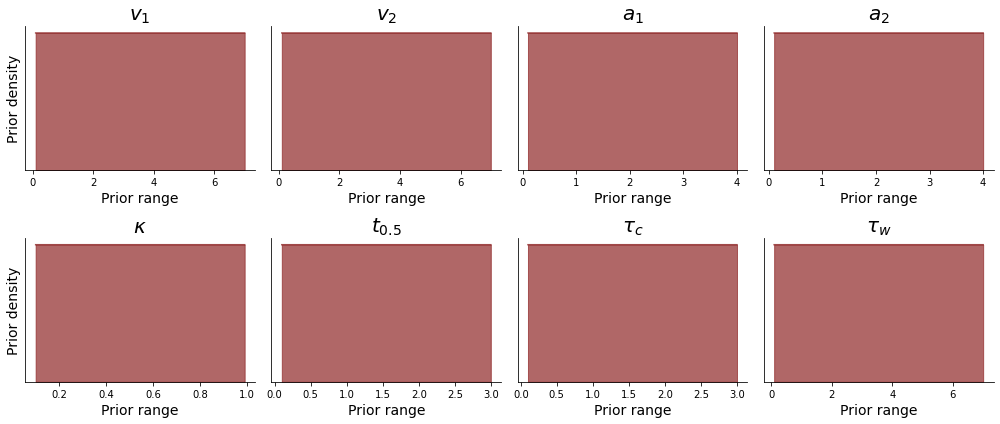

In [235]:
# Plot priors
f, axarr = plt.subplots(2, 4, figsize=(14, 6))
for i, (p, ax) in enumerate(zip(param_names, axarr.flat)):
    
    x = np.linspace(prior_low[i], prior_high[i], n_samples_prior)
    y = np.array([1 / (prior_high[i] - prior_low[i])] * n_samples_prior)
    ax.fill_between(x, y, color='#8f2727', alpha=0.7)
    ax.plot(x, y, color='#8f2727', alpha=0.8)
    ax.set_title(p, fontsize=20)
    ax.set_ylim([0, ax.get_ylim()[1]])
    sns.despine(ax=ax)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('Prior range', fontsize=14)
    if i == 0 or i == 4:
        ax.set_ylabel(r'Prior density', fontsize=14)
f.tight_layout()
f.savefig('figures/Prior_Plots_collapse.png', dpi=300)

## Prior Pushforward Checks

### Mean RT pushforward density

d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
d:\anaconda3\envs\tensorflowdev\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


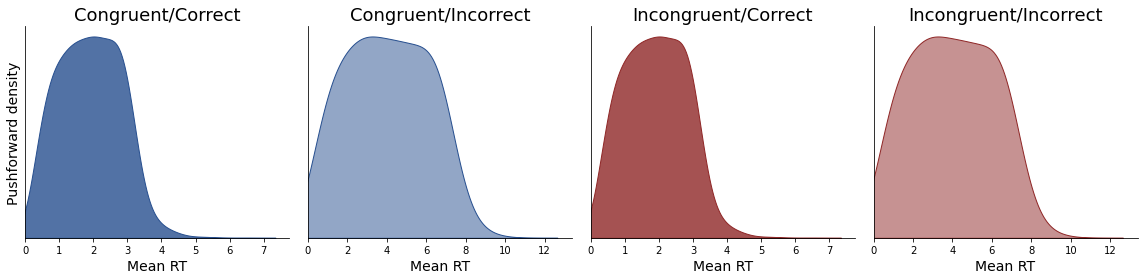

In [236]:
f, axarr = plt.subplots(1, 4, figsize=(16, 4))

rt_correct = check_data['x'][:, :, 0].copy()
rt_correct[rt_correct < 0] = np.nan

rt_incorrect = check_data['x'][:, :, 0].copy()
rt_incorrect[rt_incorrect > 0] = np.nan

rt_congruent_c = rt_correct[:, :60]
rt_incongruent_c = rt_correct[:, :60]

rt_congruent_w = rt_incorrect[:, :60]
rt_incongruent_w = rt_incorrect[:, :60]


sns.kdeplot(np.nanmean(rt_congruent_c, axis=1), ax=axarr[0],
            shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(np.abs(np.nanmean(rt_congruent_w, axis=1)), ax=axarr[1], shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(np.nanmean(rt_incongruent_c, axis=1), ax=axarr[2], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(np.abs(np.nanmean(rt_incongruent_w, axis=1)), ax=axarr[3], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, ax.get_xlim()[1]])
    sns.despine(ax=ax)
    ax.set_xlabel('Mean RT', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/Prior_Meanrt_collapsing.png', dpi=300)

### Accuracy pushforward density

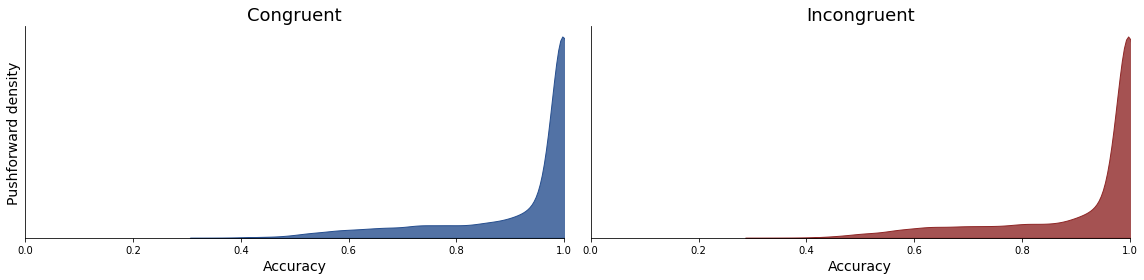

In [237]:
f, axarr = plt.subplots(1, 2, figsize=(16, 4))

rt_congruent = check_data['x'][:, :60, 0]
rt_incongruent = check_data['x'][:, 60:, 0]
rt_congruent_idx = rt_congruent > 0
rt_incongruent_idx = rt_incongruent > 0

acc_congruent = rt_congruent_idx.sum(axis=1) / 60
acc_incongruent = rt_incongruent_idx.sum(axis=1) / 60

sns.kdeplot(acc_congruent, ax=axarr[0], shade=True, color='#274f8f', alpha=0.8)
sns.kdeplot(acc_incongruent, ax=axarr[1], shade=True, color='#8f2727', alpha=0.8)

labels = ['Congruent', 'Incongruent']

for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, 1.0])
    sns.despine(ax=ax)
    ax.set_xlabel('Accuracy', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
f.tight_layout()
f.savefig('figures/Prior_Accuracy_collapsing.png', dpi=300)

### Variability pushforward density

d:\anaconda3\envs\tensorflowdev\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
d:\anaconda3\envs\tensorflowdev\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


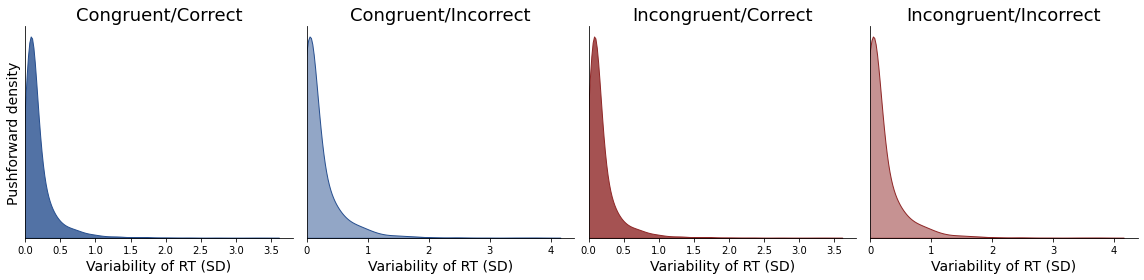

In [238]:
f, axarr = plt.subplots(1, 4, figsize=(16, 4))

rt_correct = check_data['x'][:, :, 0].copy()
rt_correct[rt_correct < 0] = np.nan

rt_incorrect = check_data['x'][:, :, 0].copy()
rt_incorrect[rt_incorrect > 0] = np.nan

rt_congruent_c = rt_correct[:, :60]
rt_incongruent_c = rt_correct[:, :60]

rt_congruent_w = rt_incorrect[:, :60]
rt_incongruent_w = rt_incorrect[:, :60]


sns.kdeplot(np.nanstd(rt_congruent_c, axis=1), ax=axarr[0],
            shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(np.nanstd(rt_congruent_w, axis=1), ax=axarr[1], shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(np.nanstd(rt_incongruent_c, axis=1), ax=axarr[2], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(np.nanstd(rt_incongruent_w, axis=1), ax=axarr[3], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_xlim([0, ax.get_xlim()[1]])
    sns.despine(ax=ax)
    ax.set_xlabel('Variability of RT (SD)', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/Prior_Varrt_collapsing.png', dpi=300)

### Skewness pushforward density

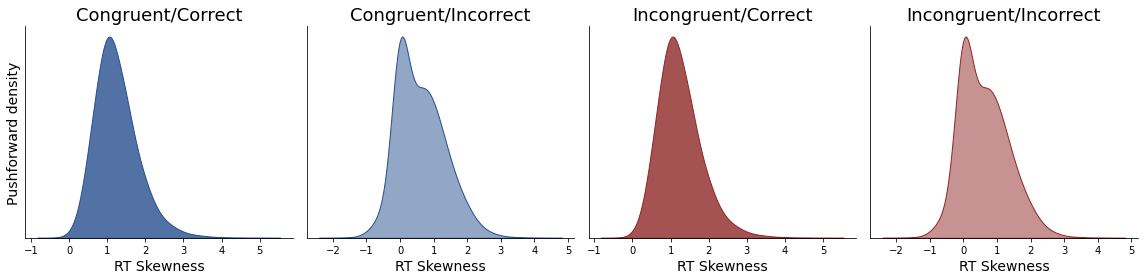

In [239]:
f, axarr = plt.subplots(1, 4, figsize=(16, 4))

rt_correct = check_data['x'][:, :, 0].copy()
rt_correct[rt_correct < 0] = np.nan

rt_incorrect = check_data['x'][:, :, 0].copy()
rt_incorrect[rt_incorrect > 0] = np.nan

rt_congruent_c = rt_correct[:, :60]
rt_incongruent_c = rt_correct[:, :60]

rt_congruent_w = rt_incorrect[:, :60]
rt_incongruent_w = rt_incorrect[:, :60]


sns.kdeplot(skew(rt_congruent_c, axis=1, nan_policy='omit'), ax=axarr[0],
            shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.8)
sns.kdeplot(skew(np.abs(rt_congruent_w), axis=1, nan_policy='omit'), ax=axarr[1], shade=True, bw_adjust=2.0, color='#274f8f', alpha=0.5)
sns.kdeplot(skew(rt_incongruent_c, axis=1, nan_policy='omit'), ax=axarr[2], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.8)
sns.kdeplot(skew(np.abs(rt_incongruent_w), axis=1, nan_policy='omit'), ax=axarr[3], shade=True, bw_adjust=2.0, color='#8f2727', alpha=0.5)

labels = ['Congruent/Correct', 'Congruent/Incorrect', 'Incongruent/Correct', 'Incongruent/Incorrect']
for i, ax in enumerate(axarr.flat):
    
    ax.set_ylim([0, ax.get_ylim()[1]])
    sns.despine(ax=ax)
    ax.set_xlabel('RT Skewness', fontsize=14)
    ax.set_yticks([])
    ax.set_title(labels[i], fontsize=18)
    
    if i == 0:
        ax.set_ylabel('Pushforward density', fontsize=14)
    else:
        ax.set_ylabel('')
    
f.tight_layout()
f.savefig('figures/Prior_Skewrt_collapsing.png', dpi=300)

# Training
One epoch on NVIDIA GTX1060 takes approximately 7.33 minutes.

In [19]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001) 

In [20]:
%%time
for ep in range(1,5+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=maximum_likelihood_loss, 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              clip_value=clip_value)
        # Store checkpoint
        manager.save()

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Wall time: 32min 54s


# Computational Faithfulness
Perform simulation-based calibration for assessing biases in the posteriors.

In [22]:
n_sbc = 5000
n_post_samples_sbc = 250
sbc_data = data_generator(n_sbc, n_obs=n_obs_test, to_tensor=False)
theta_samples = np.concatenate([model.sample(x, n_post_samples_sbc, to_numpy=True) 
                                for x in tf.split(sbc_data['x'].astype(np.float32), 10, axis=0)], axis=1)

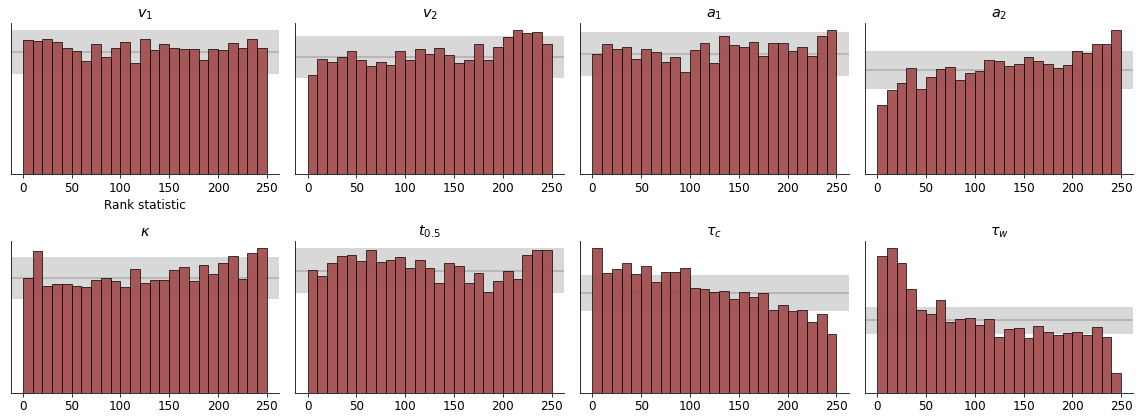

In [23]:
plot_sbc(theta_samples, 
         sbc_data['theta'], 
         param_names, 
         figsize=(16, 6), filename='SBC_5k_collapsing')

# Inferential Calibration/Model Sensitivity

## Plot true vs estimated posterior means

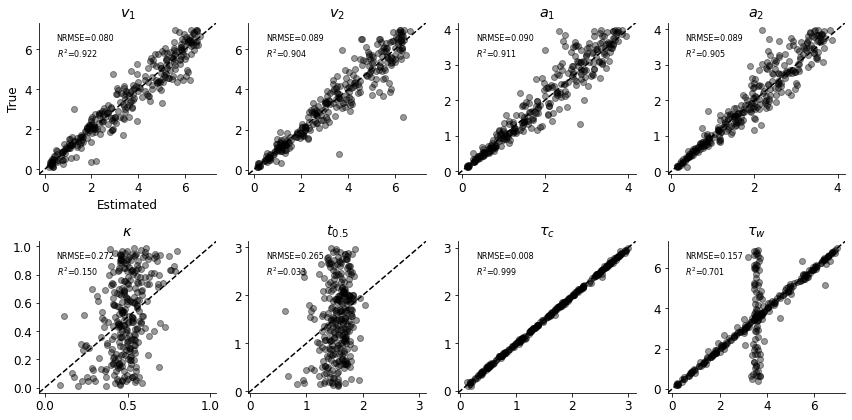

In [27]:
theta_samples = model.sample(test_data['x'], n_samples_posterior, to_numpy=True)
plot_true_est_scatter(theta_samples.mean(0), test_data['theta'], param_names, 
                      font_size_metric=8, figsize=(12, 6), filename='figures/Scatter_Params_Mean_Collapsing')

## Plot true vs estimated posterior medians

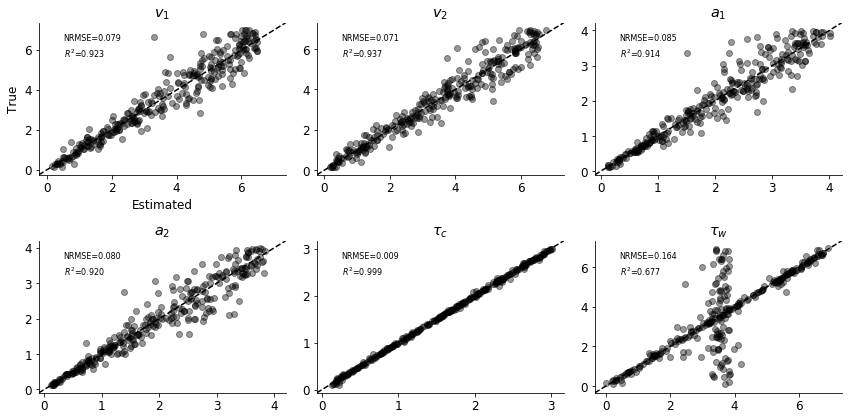

In [19]:
theta_samples = model.sample(test_data['x'], n_samples_posterior, to_numpy=True)
plot_true_est_scatter(np.median(theta_samples, axis=0), test_data['theta'], param_names, 
                      font_size_metric=8, figsize=(12, 6), filename='figures/Scatter_Params_Median')

## Posterior z-score and posterior contraction

In [29]:
# Sample from posterior
theta_samples = model.sample(test_data['x'], n_samples_posterior, to_numpy=True)

### Posterior z-score
# Compute posterior means and stds
theta_means = theta_samples.mean(0)
theta_stds = theta_samples.std(0)
theta_vars = theta_samples.var(0)

# Compute posterior z score
post_z_score = (theta_means - test_data['theta']) / theta_stds

### Posterior contraction, i.e., 1 - post_var / prior_var
prior_a = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1) # lower bound of uniform prior
prior_b = (7.0, 7.0, 4.0, 4.0, 0.99, 3.0, 3.0, 7.0) # upper bound of uniform prior

# Compute prior vars analytically
prior_vars = np.array([(b-a)**2/12 for a,b in zip(prior_a, prior_b)])
post_cont = 1 - theta_vars / prior_vars

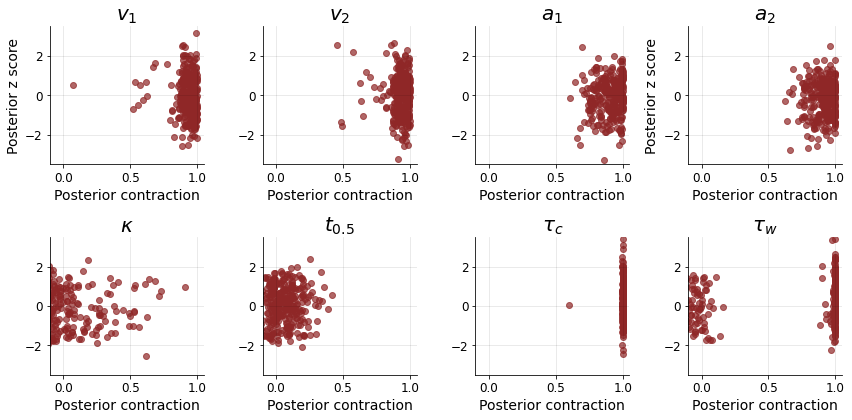

In [30]:
f, axarr = plt.subplots(2, 4, figsize=(12, 6))
for i, (p, ax) in enumerate(zip(param_names, axarr.flat)):
    

    ax.scatter(post_cont[:, i], post_z_score[:, i], color='#8f2727', alpha=0.7)
    ax.set_title(p, fontsize=20)
    sns.despine(ax=ax)
    ax.set_xlim([-0.1, 1.05])
    ax.set_ylim([-3.5, 3.5])
    ax.grid(color='black', alpha=0.1)
    ax.set_xlabel('Posterior contraction', fontsize=14)
    if i == 0 or i == 3:
        ax.set_ylabel('Posterior z score', fontsize=14)
f.tight_layout()
f.savefig('figures/BayesianChart_Collapsing.png', dpi=300)

# Model Adequacy/Posterior Predictive Checks
Perform posterior predictive checks and checks of generative performance.

## Format data

In [82]:
# # Get X_test into the correct format:

# rts = np.where(X_test[:, :, 1], -X_test[:, :, 0], X_test[:, :, 0])
# comps = X_test[:, :, 2]
# X_test = np.stack((rts, comps), axis=2)

# # Exclusion criterion (< 0.3)
# idx_300 = (np.abs(X_test[:, :, 0]) < 0.3).sum(axis=1) <= 12
# X_test = X_test[idx_300, :, :]

# # Exclusion criterion (> 10)
# idx_10000 = (np.abs(X_test)[:, :, 0] > 10.0).sum(axis=1) == 0
# X_test = X_test[idx_10000, :, :]

# # Keep only corresponding y
# y_test = y_test[idx_300, :]
# y_test = y_test[idx_10000, :]